This notebook describes the steps for the development of a tag recommendation system for StackOverflow.

In [2]:
import os
import pandas as pd
import seaborn as sns
import string
import re
from collections import defaultdict
from helper_functions import (group_sort, unique_values, freq_stats_corpora, 
                              evaluate, ngram, jaccard_distance, 
                              cosine_similarity, check_similar_tags, 
                              get_best_tags, CrossValidation, rpc_score, 
                              print_top_words, topic_name_attribution, 
                              no_tag_percentage_score)

sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load Data
The data are downloaded from StackExchange Data Explorer, with the folliwng SQL query:

SELECT TOP 50000* FROM posts WHERE CREATIONDATE>='2018-01-01' 

In [3]:
save_dir = "/Users/pmlee/Documents/CAPGemini_OpenClassroom/"+\
           "OpenClassrooms_Patrick_Lee/Assignment5/report/"

In [4]:
cur_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(cur_dir + "/db/QueryResults2018.csv", index_col=0)
df_reduced = df[df.Body.notnull()]

In [5]:
df_reduced.shape

(49969, 21)

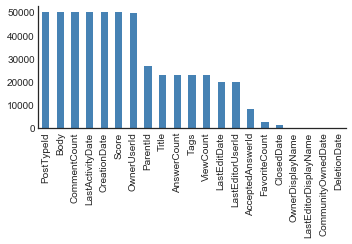

In [6]:
df_reduced_count = df_reduced.count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(5,3.5))
df_reduced_count.plot.bar(color="steelblue", ax=ax)
sns.despine()
plt.tight_layout()
fig.savefig(save_dir + "non_zero_count_analysis.pdf")

__Observation__:
- Each post has an id, PostTypeId, CommentCount, CreationDate, Score and LastActivityDate
- Tags have a significant missing values, in fact only questions have Tags and Title. 
- Body consists of questions and answers

Here, we are interested in analysing the title and body and then suggest tags to users.

In *supervised learning*, tags are the target variable, whereas in *unsupervised learning*, they are used to attribute names to topics.

In [7]:
# Combine columns
# add an empty space for distinction
df_text = pd.DataFrame(list(zip(df_reduced.Title,
                                df_reduced.Body)), index = df_reduced.index).rename(columns={
                                    0: 'TITLE',
                                    1: 'BODY',
                                })

In [8]:
# code is put in another column in the database
# tags are modified 
def stringbetweencode(data):
    if pd.notnull(data):
        p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
        return p.findall(data) 
    return data
    

def tag_between_brackets(data):
    if pd.notnull(data):
        p = re.compile(r'<(.*?)>')
        return p.findall(data)
    return data

#df_text["CODE"] = np.nan
df_text["CODE"] = df_text["BODY"].apply(stringbetweencode) 
df_text["TAGS"] = df_reduced["Tags"].apply(tag_between_brackets) 

# EDA for Tags
This section explores the statistics on tags (tags frequency analysis)

In [9]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

df_tags = df_text[df_text.TAGS.notnull()]["TAGS"]

# combine all tokens together for freq dist
tagslist = df_tags.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq = FreqDist(tagslist)

In [10]:
from operator import itemgetter
# sort by values in descending order
sorted_tagsfreq = sorted(tagsfreq.items(), key=itemgetter(1), reverse=True)
tags_key, tags_value = zip(*sorted_tagsfreq)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


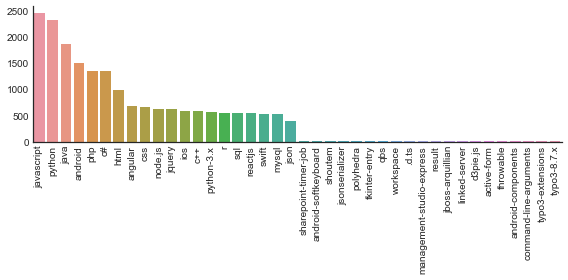

In [11]:
# tag frequency count plot
fig, ax = plt.subplots( figsize=(8, 4))
n_element = 20
x_tags = np.array(tags_key[:n_element]+ tags_key[-n_element:])
y_tags = np.array(tags_value[:n_element]+ tags_value[-n_element:])
sns.barplot(x_tags, y_tags, ax=ax)
ax.set_xticklabels(x_tags, rotation=90)
sns.despine()
plt.tight_layout()
fig.savefig(save_dir + "top_bottom_20tags.pdf")

In [150]:
# Count unique tags
unique_tags = pd.Series(list(tags_key)).nunique()
print("Num of unique tags: %d" %unique_tags)

Num of unique tags: 9509


In [13]:
pd.Series(tags_value).describe([0.5,0.75,0.9,0.95, 0.97])

count    9509.000000
mean        7.213692
std        54.839911
min         1.000000
50%         1.000000
75%         3.000000
90%         9.000000
95%        18.000000
97%        31.000000
max      2455.000000
dtype: float64

__Observation__:
- 50% of the tags only occur once, we will eliminate tags that have low counts, taking the arg of 97% as threshold

## Text preprocessing with scikit learn and NLTK
Here the unstructure text goes through a series of process for vectorization.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk import regexp_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pdb

wnl = WordNetLemmatizer()


def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return 'n'  #None


def lemmatizer(doc):
    """
    returns lemmatized tokens after removing stop words and pos tagging
    
    Parameters:
    -----------
    doc: pandas dataframe
        text description in df
    
    Return:
    -------
    pandas dataframe
        lemmatized, pos_tagged, and removed stopwords tokens
    """
    if pd.notnull(doc):
        # add words to stoplist, previously punctuations have been removed,
        # so we should do the same for the stoplist
        # we also add the top 10 words in the stoplist, these top 10 words
        # are found after post-processing

        stoplist = [striphtmlpunct(x)
                    for x in stopwords.words('english')] + ['im', 'ive'] + [
                        'use', 'get', 'like', 'file', 'would', 'way', 'code',
                        'work', 'want', 'need'
                    ]

        lemmatized = []

        regex_tokens = regexp_tokenize(doc, pattern='\w+\S+|\.\w+')

        for word, p_tags in pos_tag(regex_tokens):
            convert_pos_tag = convert_tag(p_tags)
            lemmatized_word = wnl.lemmatize(word, pos=convert_pos_tag)
            
            if lemmatized_word not in set(stoplist):
                lemmatized.append(lemmatized_word)

        return pd.Series(' '.join(lemmatized))
    return pd.Series(doc)


def postagged(data):
    convert_pos_tag = []

    if pd.notnull(data):
        tokens = regexp_tokenize(data, pattern='\w+\S+|\.\w+')

        for word, p_tags in pos_tag(tokens):
            convert_pos_tag.append(convert_tag(p_tags))
    return convert_pos_tag


def striphtmlpunct(data):
    # remove html tags, code unnecessary punctuations
    # <.*?> to remove everything between <>
    # [^\w\s+\.\-\#\+] remove punctuations except .-#+
    # (\.{1,3})(?!\S) negative lookahead assertion: only match .{1,3} that
    # is followed by white space
    if pd.notnull(data):
        p = re.compile(r'<.*?>|[^\w\s+\.\-\#\+]')
        res = p.sub('', data)
        pe = re.compile('(\.{1,3})(?!\S)')

        return pe.sub('', res)

    return data


def stripcode(data):
    p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
    return p.sub('', data)


def striptabs(data):
    # remove tabs breaklines
    p = re.compile(r'(\r\n)+|\r+|\n+|\t+/i')
    return p.sub(' ', data)


def lower(data):
    if pd.notnull(data):
        return data.lower()
    return data


# remove html tags
df_text["BODY_STRIPPED"] = df_text.BODY.apply(lower).apply(stripcode).apply(
    striphtmlpunct).apply(striptabs)
df_text["CODE_STRIPPED"] = df_text.CODE.apply(
    lambda x: [striptabs(line.lower()) for line in x if x])
df_text["TITLE_STRIPPED"] = df_text.TITLE.apply(lower).apply(striphtmlpunct)

# remove stop words, pos_tag, and lemmatize
df_text["BODY_LEMMATIZED"] = df_text["BODY_STRIPPED"].apply(lemmatizer)
df_text["TITLE_LEMMATIZED"] = df_text["TITLE_STRIPPED"].apply(lemmatizer)

# postagged column for EDA
df_text["BODY_POSTAGGED"] = df_text["BODY_STRIPPED"].apply(postagged)
df_text["TITLE_POSTAGGED"] = df_text["TITLE_STRIPPED"].apply(postagged)

## Eliminate entries without tags
The preprocessing is done for all documents in the collection, but for supervised learning only documents with tags are retained.

In [15]:
df_text_reduced = df_text.loc[df_tags.index]

In [13]:
df_text_reduced.sample(3, random_state=344)

,TITLE,BODY,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED,BODY_POSTAGGED,TITLE_POSTAGGED
Id,,,,,,,,,,,
49047792,nodejs SSL handshake error on aws,<p>I am trying to hit third party api splash p...,"[var options = {\n method: 'post',\n bod...","[node.js, amazon-web-services]",i am trying to hit third party api splash paym...,"[var options = { method: 'post', body:...",nodejs ssl handshake error on aws,try hit third party api splash payment nodejs ...,nodejs ssl handshake error aws,"[v, v, n, v, a, n, n, a, n, n, n, a, n, n, v, ...","[a, n, v, n, n, n]"
49043638,Asynchronous problems in C#,"<p>I am learning C# and in order to train, I w...",[TaskCompletionSource&lt;bool&gt; tcs = null; ...,"[c#, .net, asynchronous]",i am learning c# and in order to train i would...,[taskcompletionsource&lt;bool&gt; tcs = null; ...,asynchronous problems in c#,learn c# order train make powerpoint addin ask...,asynchronous problem c#,"[v, v, n, n, n, n, n, v, n, v, n, v, n, n, v, ...","[a, n, n, n]"
50428018,Facebook instant article URL Claim,<p>I'm not getting the exact way to claim the ...,[],"[facebook, facebook-instant-articles]",im not getting the exact way to claim the url ...,[],facebook instant article url claim,exact claim url facebook instant article site ...,facebook instant article url claim,"[n, r, v, n, a, n, n, v, n, n, n, n, a, n, n, ...","[n, a, n, a, n]"


## Sample

In [19]:
n_example = df_text_reduced[np.logical_and(df_text_reduced.CODE_STRIPPED.notnull(),
                             df_text_reduced.TITLE.notnull())].sample(1, random_state=18).index[0]

In [20]:
df_text_reduced.loc[n_example].TITLE

'Python encapsulate data for a class'

In [22]:
df_text_reduced.loc[n_example].TITLE_LEMMATIZED

'python encapsulate data class'

In [21]:
df_text_reduced.loc[n_example].BODY

'<p>I have two python classes, A and B that inherits from A.\nAt runtime, I only have one instance of class A, but many instances of class B.</p>\n\n<pre><code>class A:\n  def __init__(self, a):\n    self.a = a\n\n  def _init2 (self, AA)\n    self.a = AA.a\n\nclass B(A):\n  def __init__(self, AA, b):\n    super()._init2(AA)\n    self.b = b\n\nAA = A(0)\nBB = B(AA, 1)\n</code></pre>\n\n<p>Is this the good way of writing it ? It seems ugly ...</p>\n'

In [24]:
df_text_reduced.loc[n_example].BODY_LEMMATIZED

'two python class inherit runtime one instance class many instance class good write seem ugly'

In [25]:
df_text_reduced.loc[n_example].CODE_STRIPPED

['class a:   def __init__(self, a):     self.a = a   def _init2 (self, aa)     self.a = aa.a class b(a):   def __init__(self, aa, b):     super()._init2(aa)     self.b = b aa = a(0) bb = b(aa, 1) ']

## Eliminate low count tags
Since there is a total of ~9500 unique tags, some tags might be considered as outliers. We perform a count analysis on these tags, and eliminate the outliers. We only keep the top 3% tags with the higest count.

In [26]:
def remove_low_count_tags(data, tags_key=None):

    reduced = []
    for el in data:
        if el in set(tags_key):
            reduced.append(el)

    if not reduced:
        reduced = np.NaN

    return reduced


# combine all tokens together for freq dist
tagslist_reduced = df_text_reduced.TAGS.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq_reduced = FreqDist(tagslist_reduced)
sorted_tagsfreq_reduced = sorted(
    tagsfreq_reduced.items(), key=itemgetter(1), reverse=True)
tags_key_reduced, tags_value_reduced = zip(*sorted_tagsfreq_reduced)

# drop keywords that have less than tag_freq
quartile = 0.97
n_tag = pd.Series(tags_value_reduced).quantile([quartile]).values[0]
sorted_tagsfreq_reduced_quartile = [
    el for el in sorted_tagsfreq_reduced if el[1] > n_tag
]
tags_key_reduced_quartile, tags_value_reduced_quartile = zip(
    *sorted_tagsfreq_reduced_quartile)
df_tags_temp = df_text_reduced.TAGS.apply(
    remove_low_count_tags, tags_key=tags_key_reduced_quartile)
df_text_reduced["TAGS_MODIFIED"] = df_tags_temp
df_tags_reduced = df_text_reduced[df_text_reduced.TAGS_MODIFIED.notnull()]

In [27]:
pd.Series(tags_value_reduced).describe([0.5,0.9,0.95,0.97])

count    9509.000000
mean        7.213692
std        54.839911
min         1.000000
50%         1.000000
90%         9.000000
95%        18.000000
97%        31.000000
max      2455.000000
dtype: float64

In [28]:
tags_unique_len = pd.Series(tags_key_reduced_quartile).nunique()
print("We keep %.d unique tags." %(tags_unique_len))

We keep 280 unique tags


In [151]:
print("After eliminating the low count tags, %.1f%% of the documents still have at least one tag." %(100*len(df_tags_reduced)/len(df_tags)))

After eliminating the low count tags, 89.7% of the documents still have at least one tag.


In [30]:
df_tags_reduced.shape

(20721, 12)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


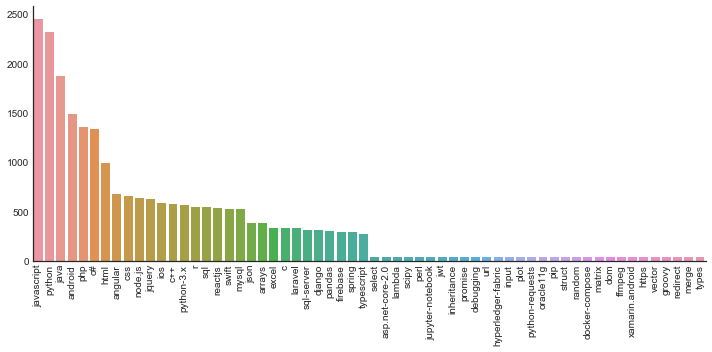

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

n_element = 30
key_tags_key_reduced = (tags_key_reduced_quartile[:n_element] +
                        tags_key_reduced_quartile[-n_element:])
value_tags_key_reduced = (tags_value_reduced_quartile[:n_element] +
                          tags_value_reduced_quartile[-n_element:])

sns.barplot(
    np.array(key_tags_key_reduced), np.array(value_tags_key_reduced), ax=ax)
ax.set_xticklabels(key_tags_key_reduced, rotation=90)
#ax.set_title('Top 50 words for %s from title' %key)
sns.despine()
plt.tight_layout()
fig.savefig(save_dir + "sanity_check.pdf")

## Word types statistics in the collection of document
We study the statistics of the word functions.

### From Title

In [32]:
# combine all tokens together for freq dist
postags_title = df_text_reduced.TITLE_POSTAGGED.sum()

postagsfreq_reduced = FreqDist(postags_title)
sorted_postagsfreq_reduced = sorted(
    postagsfreq_reduced.items(), key=itemgetter(1), reverse=True)
postags_key_reduced, postags_value_reduced = zip(*sorted_postagsfreq_reduced)
norm_value_title = np.array(postags_value_reduced)/len(postags_title)

### From Body

In [33]:
# combine all tokens together for freq dist
postags_body = df_text_reduced.BODY_POSTAGGED.sum()

postagsfreq_body = FreqDist(postags_body)
sorted_postagsfreq_body = sorted(
    postagsfreq_body.items(), key=itemgetter(1), reverse=True)
postags_key_body, postags_value_body = zip(*sorted_postagsfreq_body)
norm_value_body = np.array(postags_value_body)/len(postags_body)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


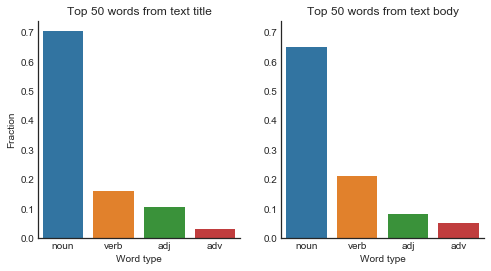

In [34]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharey=True)
n_element = 50
sns.barplot(
    np.array(postags_key_reduced),
    np.array(norm_value_title),
    ax=ax[0])
sns.barplot(
    np.array(postags_key_body),
    np.array(norm_value_body),
    ax=ax[1])
ax[0].set_xticklabels(["noun", "verb", "adj", "adv"])
ax[0].set_title('Top 50 words from text title' )
ax[1].set_xticklabels(["noun", "verb", "adj", "adv"])
ax[1].set_title('Top 50 words from text body')
ax[0].set_ylabel('Fraction')
ax[0].set_xlabel("Word type")
ax[1].set_xlabel("Word type")

sns.despine()

## Bag-of-words distribution associated to a tag
We perform an analysis to look at the word distrbution for each tag.

### On text title

In [35]:
df_text_reduced_tokens = df_text_reduced.loc[
    :, "TITLE_LEMMATIZED"].apply(lambda x: x.split())
df_tags_title = pd.DataFrame(
    list(zip(df_tags_reduced.TAGS_MODIFIED,
             df_text_reduced_tokens))).rename(columns={
                 0: "elkey",
                 1: "elvalue"
             })

In [36]:
corpfreq_title, corpstats_title, corpora_title = freq_stats_corpora(
    df_tags_title)

In [37]:
# sort by values in descending order
sorted_corpfreq_title = defaultdict(list)
cutoff = 10

for tag, tagfreq in corpfreq_title.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_title[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


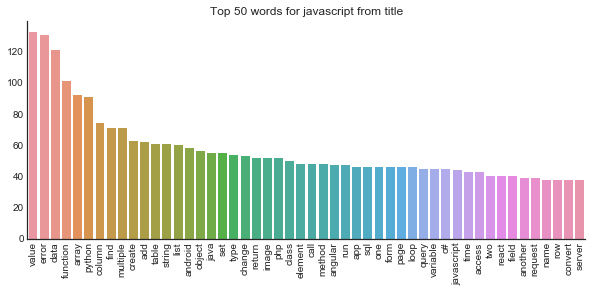

In [38]:
token_index = 10
key = list(sorted_corpfreq_title.keys())[token_index]
corptags_key_title, corptags_value_title = zip(*sorted_corpfreq_title[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_title[:n_element]),
    np.array(corptags_value_title[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_title[:n_element], rotation=90)
ax.set_title('Top 50 words for %s from title' %key)
sns.despine()

### On text body

In [39]:
df_body_reduced_tokens = df_text_reduced.loc[
    :, "BODY_LEMMATIZED"].apply(lambda x: x.split())

df_tags_body = pd.DataFrame(
    list(
        zip(df_tags_reduced.TAGS_MODIFIED,
            df_body_reduced_tokens))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [40]:
corpfreq_body, corpstats_body, corpora_body = freq_stats_corpora(df_tags_body)

In [41]:
# sort by values in descending order
sorted_corpfreq_body = defaultdict(list)
cutoff = 1
cutoff_doc = 50
n_most_common = 20
# most frequent words will be the corpora that we use as a dictionary
most_frequent_words = defaultdict(list)

for tag, tagfreq in corpfreq_body.items():
    # only add into sorted_corpfreq if the word occurencces > cutoff_doc
    if sum(list(tagfreq.values())) > cutoff_doc:
    
        most_frequent_words[tag] = set(
            i[0] for i in tagfreq.most_common(n_most_common) if i[1] > cutoff)
        sorted_corpfreq_body[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


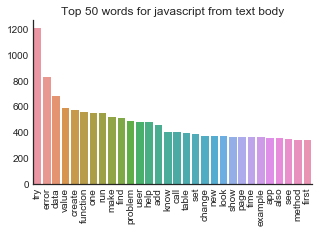

In [42]:
token_index = 10
key = list(sorted_corpfreq_body.keys())[token_index]
corptags_key_body, corptags_value_body = zip(*sorted_corpfreq_body[key])
fig, ax = plt.subplots(figsize=(5, 3))
n_element = 30
sns.barplot(
    np.array(corptags_key_body[:n_element]),
    np.array(corptags_value_body[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_body[:n_element], rotation=90)
ax.set_title(
    'Top 50 words for %s from text body' %key)
sns.despine()

## Tags similarity
Some tags are similar etymologically and contextually. In this section, we aim on finding tags that are similar and grouping them together. In the supervised learning approach, we aim to develop a tolerant evaluation metric by incorporating a similar tags graph. 

### Similar etymology tags
We build sets of trigrams for each tag, and we compute the pariwise Cosine similarity.

In [43]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
selection_threshold =0.5

sim_word_cosine = defaultdict(list)
sim_word_jaccard = defaultdict(list)

for i in range(len(tags_key_reduced_quartile)):
    for j in range(len(tags_key_reduced_quartile)):
        word_i = tags_key_reduced_quartile[i]
        word_j = tags_key_reduced_quartile[j]
        
        # Porter stem to avoid matching words that have the same ending
        # such as serialization, internationalization
        word_i_lem = stemmer.stem(word_i)
        word_j_lem = stemmer.stem(word_j)
        
        # generation of trigrams
        trigrams_i = ngram(word_i_lem, 3)
        trigrams_j = ngram(word_j_lem, 3)

        cosine_sim = cosine_similarity(trigrams_i, trigrams_j)
        jaccard_sim = jaccard_distance(trigrams_i, trigrams_j)

        if cosine_sim >= selection_threshold and cosine_sim < 0.98:
            sim_word_cosine[tags_key_reduced_quartile[i]].append({
                tags_key_reduced_quartile[j]:
                cosine_sim
            })

        if jaccard_sim >= selection_threshold and jaccard_sim < 1.:
            sim_word_jaccard[tags_key_reduced_quartile[i]].append({
                tags_key_reduced_quartile[j]:
                jaccard_sim
            })
        

In [44]:
# Create a dataframe to illustrate the differences
df_tags_word = pd.DataFrame()

for key, values in sim_word_cosine.items():
    for i in range(len(sim_word_cosine[key])):
        try:
            jaccard_entry = list(sim_word_jaccard[key][i].keys())[0]
        except IndexError:
            jaccard_entry = np.NaN

        try:
            cosine_entry = list(sim_word_cosine[key][i].keys())[0]
        except IndexError:
            cosine_entry = np.NaN
            
        df_tags_word = df_tags_word.append(
            {
                "TAG": key,
                "TAG_JACCARD": jaccard_entry,
                "TAG_COSINE": cosine_entry
            },
            ignore_index=True)

In [45]:
df_tags_word = pd.DataFrame(df_tags_word[["TAG",
                                          "TAG_COSINE"]]).set_index("TAG")
df_tags_word.columns = ["A_TAG"]
df_tags_word.head(10)

,A_TAG
TAG,
javascript,ecmascript-6
python,python-3.x
python,python-2.7
python,python-3.6
python,python-requests
java,javafx
java,java-8
android,android-studio
android,android-layout


### Similar context tags
We look at the word distribution of each tag, and compute a pairwise Jaccard distance between vectors of word distrbutions.

In [46]:
keys_body = list(sorted_corpfreq_body.keys())
tags_merge = pd.DataFrame()

for i in range(len(keys_body)):
    pd_columns = [val[0] for val in sorted_corpfreq_body[keys_body[i]]]
    pd_values = [[val[1] for val in sorted_corpfreq_body[keys_body[i]]]]
    temp_tags = pd.DataFrame(
        pd_values, columns=pd_columns, index=[keys_body[i]]).astype(int)
    # merge to construct the tag term matrix
    tags_merge = pd.concat([tags_merge, temp_tags], axis=0, sort=True)

tags_merge = tags_merge.fillna(0)

In [47]:
new_tags_merge = tags_merge[tags_merge.sum(axis=1)>0]
#new_tags_merge["SUM"] = new_tags_merge.sum(axis=1)

In [48]:
from sklearn.metrics.pairwise import pairwise_distances

tags_cosine = pairwise_distances(new_tags_merge, metric="cosine")
tags_hamming = pairwise_distances(new_tags_merge, metric="hamming")

# jaccard distance requires boolean type
tags_jaccard = pairwise_distances(new_tags_merge, metric="jaccard")

/Users/pmlee/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [49]:
def tag_distance(df, v_thres):
    # comparing distances, the lower the better
    tags_adjlist = []

    for i in range(len(keys_body) - 1):

        for j in range(i + 1, len(keys_body) - 1):
            temp_list = [keys_body[i]]
            if df[i, j] < v_thres:
                temp_list.append(keys_body[j])
            else:
                temp_list.append(np.NaN)

            tags_adjlist.append(temp_list)

            #reset list
            temp_list = []
    return tags_adjlist


df_tags_jaccard = pd.DataFrame(
    tag_distance(tags_jaccard, 0.7), columns=["TAG",
                                              "Jaccard"]).set_index("TAG")
df_tags_cosine = pd.DataFrame(
    tag_distance(tags_cosine, 0.05), columns=["TAG",
                                              "Cosine"]).set_index("TAG")
df_tags_hamming = pd.DataFrame(
    tag_distance(tags_hamming, 0.015), columns=["TAG",
                                                "Hamming"]).set_index("TAG")

df_tags_jaccard = df_tags_jaccard.dropna(axis=0, how="all")
df_tags_cosine = df_tags_cosine.dropna(axis=0, how="all")
df_tags_hamming = df_tags_hamming.dropna(axis=0, how="all")

In [50]:
df_tags_jaccard.columns = ["A_TAG"]
df_tags_jaccard.head(10)

,A_TAG
TAG,
android,java
sql,mysql
sql,sql-server
regex,string
api,apache-spark
api,rest
api,asp.net-mvc
pandas,dataframe
pandas,python-3.x


### Concatenate both similar etymology words and contextual words

In [70]:
df_tags_sim = pd.concat(
    [df_tags_jaccard,
     df_tags_word]).reset_index().drop_duplicates().set_index("TAG")

### Using networkx to store sim_tags

In [71]:
# network x
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# use a bidirectional graph
G_tags = nx.Graph()
node2link = zip(df_tags_sim.index, df_tags_sim.A_TAG)
G_tags.add_nodes_from(list(df_tags_sim.index))
G_tags.add_edges_from(node2link)

In [72]:
info = nx.info(G_tags)
print(info)

Name: 
Type: Graph
Number of nodes: 193
Number of edges: 192
Average degree:   1.9896


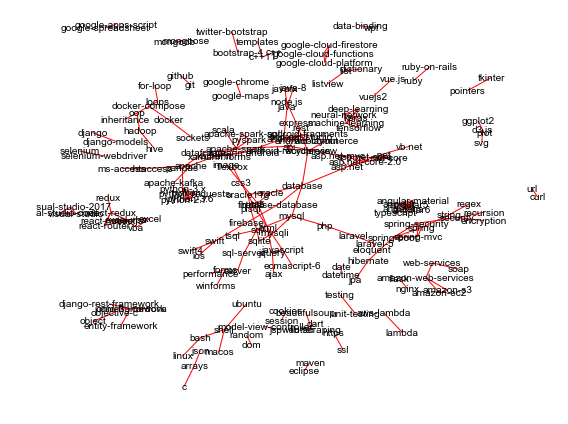

In [73]:
# Similar tag graph
pos = nx.spring_layout(
    G_tags, k=.9 * 1 / np.sqrt(len(G_tags.nodes())), iterations=20)
fig, ax = plt.subplots(figsize=(8, 6))

nx.draw(
    G_tags,
    pos,
    node_size=0,
    alpha=1,
    with_labels=True,
    edge_color='red',
    font_size=10,
    ax=ax)
plt.tight_layout()
fig.savefig(save_dir + "similar_tag_graph.pdf")

__Observation__:
- a similar tags graph is constructed with 193 nodes.
- similar tags are clustered together and linked by red edges
- there are some mistakes, example url and curl, but the model will be smart enough to not predict url for a question that is on curl.

# Supervised learning: ScikitLearn OneVsRest Classifier

In [74]:
# Some flags
l_crossval = False

## Prepare the input and output
we use text and body combined together as input.

### Random sampling
We choose only 10000 samples to speed up the training.

In [75]:
df_tags_reduced_sampled = df_tags_reduced.sample(10000, random_state=2)

### Label binarization
We use multilabel binarizer to convert tags in string to vectors in boolean.

In [76]:
from sklearn.preprocessing import MultiLabelBinarizer

lb = MultiLabelBinarizer()
targets = lb.fit_transform(df_tags_reduced_sampled.TAGS_MODIFIED)

### Train/crossval/test split
Here we apply a 80/20 rule.

In [77]:
X_counts = df_tags_reduced_sampled.TITLE_LEMMATIZED \
            +' '+ df_tags_reduced_sampled.BODY_LEMMATIZED

# shuffle indices
idx = np.arange(X_counts.shape[0])
np.random.seed(23)
np.random.shuffle(idx)

# Generate train/crossval/test sets
train_size = int(.8 * X_counts.shape[0])

X_train = X_counts.iloc[idx[:train_size]]
y_train = targets[idx[:train_size],:]
X_test = X_counts.iloc[idx[train_size:]]
y_test = targets[idx[train_size:],:]

## Study of the most frequent words with respect to ngrams
This study allows us to decide on how many number of features is necessary for supervised model trainings.

In [78]:
df_X_counts = X_counts.apply(lambda x: x.split())
# combine all tokens together for freq dist
X_counts_corpora = df_X_counts.sum()

### Unigrams

In [79]:
X_count_freq = FreqDist(X_counts_corpora)
sorted_X_count_freq = sorted(X_count_freq.items(), key = itemgetter(1), reverse=True)
X_counts_key, X_counts_value = zip(*sorted_X_count_freq)

In [80]:
df_X_counts = pd.DataFrame(
    list(zip(X_counts_key, X_counts_value)), columns=["WORD", "FREQ"])
df_X_counts.FREQ.describe([0.8, 0.9, 0.95])

count    35114.000000
mean        12.970012
std         94.196039
min          1.000000
50%          1.000000
80%          3.000000
90%          9.000000
95%         30.000000
max       5353.000000
Name: FREQ, dtype: float64

In [81]:
df_X_counts_90 = df_X_counts[df_X_counts.FREQ>df_X_counts.FREQ.quantile(0.9)]
print("Total number of words: {}, we'll take only the top 10%: {} words".format(
    len(X_counts_key), len(df_X_counts_90)))

Total number of words: 35114, we'll take only the top 10%: 3367 words


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


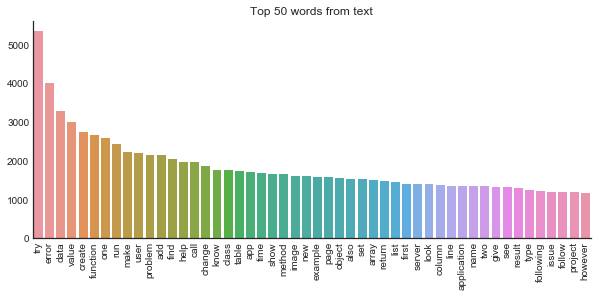

In [82]:
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(X_counts_key[:n_element]),
    np.array(X_counts_value[:n_element]),
    ax=ax)
ax.set_xticklabels(X_counts_key[:n_element], rotation=90)
ax.set_title(
    'Top 50 words from text')
sns.despine()

__Observation__:
- more than 50% of the words only have 1 occurence, we can a limit at the selection of max features. Here top 5% of the words have >= 19 occurences, we can reduce our number choice of words to the top 5%.

### Bigrams

In [83]:
from nltk import bigrams
X_count_corpora_bi = bigrams(X_counts_corpora)
X_count_freq_bi = FreqDist(X_count_corpora_bi)
sorted_X_count_freq_bi = sorted(X_count_freq_bi.items(), key = itemgetter(1), reverse=True)
X_counts_key_bi, X_counts_value_bi = zip(*sorted_X_count_freq_bi)
X_counts_join_key_bi = [" ".join(w) for w in X_counts_key_bi]

In [84]:
df_X_counts_bi = pd.DataFrame(
    list(zip(X_counts_join_key_bi, X_counts_value_bi)),
    columns=["WORD", "FREQ"])
df_X_counts_bi.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    294772.000000
mean          1.545018
std           2.897238
min           1.000000
50%           1.000000
80%           1.000000
90%           2.000000
95%           4.000000
98%           6.000000
max         351.000000
Name: FREQ, dtype: float64

In [85]:
df_X_counts_bi_90 = df_X_counts_bi[
    df_X_counts_bi.FREQ > df_X_counts_bi.FREQ.quantile(0.9)]
print("Total number of words: {}, we'll take only the top 10%: {} words".format(
    len(X_counts_join_key_bi), len(df_X_counts_bi_90)))

Total number of words: 294772, we'll take only the top 10%: 25846 words


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


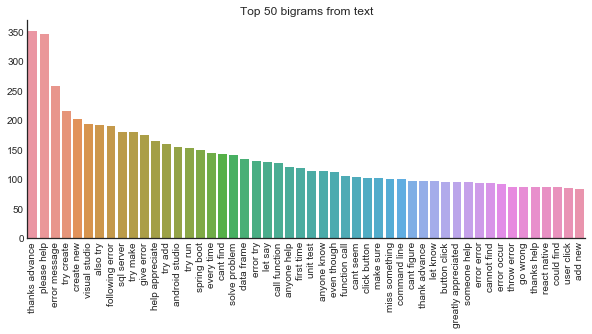

In [86]:
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(X_counts_join_key_bi[:n_element]),
    np.array(X_counts_value_bi[:n_element]),
    ax=ax)
ax.set_xticklabels(X_counts_join_key_bi[:n_element], rotation=90)
ax.set_title(
    'Top 50 bigrams from text')
sns.despine()

### Trigrams

In [87]:
from nltk import trigrams
X_count_corpora_tri = trigrams(X_counts_corpora)
X_count_freq_tri = FreqDist(X_count_corpora_tri)
sorted_X_count_freq_tri = sorted(X_count_freq_tri.items(), key = itemgetter(1), reverse=True)
X_counts_key_tri, X_counts_value_tri = zip(*sorted_X_count_freq_tri)
X_counts_join_key_tri = [" ".join(w) for w in X_counts_key_tri]

In [88]:
df_X_counts_tri = pd.DataFrame(
    list(zip(X_counts_join_key_tri, X_counts_value_tri)),
    columns=["WORD", "FREQ"])
df_X_counts_tri.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    434815.000000
mean          1.047404
std           0.399979
min           1.000000
50%           1.000000
80%           1.000000
90%           1.000000
95%           1.000000
98%           2.000000
max          65.000000
Name: FREQ, dtype: float64

In [89]:
df_X_counts_tri_90 = df_X_counts_tri[
    df_X_counts_tri.FREQ > df_X_counts_tri.FREQ.quantile(0.9)]
print("Total number of words: {}, we'll take only the top 2%: {} words".format(
    len(X_counts_join_key_tri), len(df_X_counts_tri_90)))

Total number of words: 434815, we'll take only the top 2%: 14301 words


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


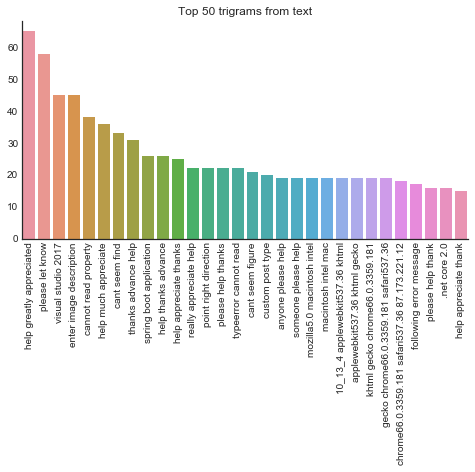

In [90]:
fig, ax = plt.subplots(figsize=(8, 4))
n_element = 30
sns.barplot(
    np.array(X_counts_join_key_tri[:n_element]),
    np.array(X_counts_value_tri[:n_element]),
    ax=ax)
ax.set_xticklabels(X_counts_join_key_tri[:n_element], rotation=90)
ax.set_title(
    'Top 50 trigrams from text')
sns.despine()

### Unigrams + Bigrams

In [91]:
df_X_counts_mono_bi = pd.DataFrame(
    list(zip(X_counts_key, X_counts_value)) +
    list(zip(X_counts_join_key_bi, X_counts_value_bi)),
    columns=["WORD", "FREQ"])
df_X_counts_mono_bi.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    329886.000000
mean          2.761127
std          31.053946
min           1.000000
50%           1.000000
80%           2.000000
90%           3.000000
95%           4.000000
98%           9.000000
max        5353.000000
Name: FREQ, dtype: float64

In [92]:
df_X_counts_mono_bi_90 = df_X_counts_mono_bi[
    df_X_counts_mono_bi.FREQ > df_X_counts_mono_bi.FREQ.quantile(0.9)]
print(
    "Total number of words: {}, we'll take only the top 10%: {} words".format(
        len(df_X_counts_mono_bi), len(df_X_counts_mono_bi_90)))

Total number of words: 329886, we'll take only the top 10%: 21714 words


### Bigrams + Trigrams

In [93]:
df_X_counts_bi_tri = pd.DataFrame(
    list(zip(X_counts_join_key_bi, X_counts_value_bi)) +
    list(zip(X_counts_join_key_tri, X_counts_value_tri)),
    columns=["WORD", "FREQ"])
df_X_counts_bi_tri.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    729587.000000
mean          1.248453
std           1.883176
min           1.000000
50%           1.000000
80%           1.000000
90%           1.000000
95%           2.000000
98%           4.000000
max         351.000000
Name: FREQ, dtype: float64

In [94]:
df_X_counts_bi_tri_90 = df_X_counts_bi_tri[
    df_X_counts_bi_tri.FREQ > df_X_counts_bi_tri.FREQ.quantile(0.90)]
print("Total number of words: {}, we'll take only the top 10%: {} words".format(
    len(df_X_counts_bi_tri), len(df_X_counts_bi_tri_90)))

Total number of words: 729587, we'll take only the top 10%: 72415 words


### Unigrams + Bigrams + Trigrams

In [95]:
df_X_counts_mono_tri = pd.DataFrame(
    list(zip(X_counts_key, X_counts_value)) +
    list(zip(X_counts_join_key_bi, X_counts_value_bi)) +
    list(zip(X_counts_join_key_tri, X_counts_value_tri)),
    columns=["WORD", "FREQ"])
df_X_counts_mono_tri.FREQ.describe([0.8, 0.9, 0.95, 0.98])

count    764701.000000
mean          1.786690
std          20.416234
min           1.000000
50%           1.000000
80%           1.000000
90%           2.000000
95%           2.000000
98%           5.000000
max        5353.000000
Name: FREQ, dtype: float64

In [96]:
df_X_counts_mono_tri_90 = df_X_counts_mono_tri[
    df_X_counts_mono_tri.FREQ > df_X_counts_mono_tri.FREQ.quantile(0.90)]
print("Total number of words: {}, we'll take only the top 10%: {} words".format(
    len(df_X_counts_mono_tri), len(df_X_counts_mono_tri_90)))

Total number of words: 764701, we'll take only the top 10%: 37273 words


## Training with Dummy Classifier (strategy=prior)
__Count vectorizer__ 

In [97]:
def tokenize(text):
    return text.split(' ')

params_vectorizer = {'max_features': len(df_X_counts_90), 
                     'tokenizer' :tokenize, 'lowercase':False}

In [98]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.feature_extraction.text import CountVectorizer

Dummy_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(DummyClassifier(strategy='prior'))),
])

Dummy_pipeline_count.fit(X_train, y_train)
# compute the testing accuracy
y_pred_count_dummy = Dummy_pipeline_count.predict(X_test)
y_pred_proba_count_dummy = Dummy_pipeline_count.predict_proba(X_test)
y_pred_new_count_dummy = get_best_tags(y_pred_count_dummy,
                                       y_pred_proba_count_dummy, n_tags=3)
score_dummy_count = evaluate(
    y_test,
    y_pred_new_count_dummy,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_dummy_count))

Test score: 0.14


__Tfidf vectorizer__ 

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

Dummy_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(DummyClassifier(strategy='prior'))),
])

Dummy_pipeline_tfidf.fit(X_train, y_train)
# compute the testing accuracy
y_pred_tfidf_dummy = Dummy_pipeline_tfidf.predict(X_test)
y_pred_proba_tfidf_dummy = Dummy_pipeline_tfidf.predict_proba(X_test)
y_pred_new_tfidf_dummy = get_best_tags(y_pred_tfidf_dummy,
                                       y_pred_proba_tfidf_dummy, n_tags=3)
score_dummy_tfidf = evaluate(
    y_test,
    y_pred_new_tfidf_dummy,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_dummy_tfidf))

Test score: 0.14


## Training with Naive Bayes Classifier
__Count vectorizer__ 

In [100]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(
        MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline_count.fit(X_train, y_train)
# compute the testing accuracy
y_pred_count = NB_pipeline_count.predict(X_test)
y_pred_proba_count = NB_pipeline_count.predict_proba(X_test)
y_pred_new_count = get_best_tags(y_pred_count, y_pred_proba_count, n_tags=3)

score_nb_count, errors_count = evaluate(
    y_test,
    y_pred_new_count,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=True,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_nb_count))

Test score: 0.43


__Tfidf vectorizer__

In [101]:
NB_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(
        MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline_tfidf.fit(X_train, y_train)
# compute the testing accuracy
y_pred_tfidf = NB_pipeline_tfidf.predict(X_test)
y_pred_proba_tfidf = NB_pipeline_tfidf.predict_proba(X_test)
y_pred_new_tfidf = get_best_tags(y_pred_tfidf, y_pred_proba_tfidf, n_tags=3)

score_nb_tfidf, errors_tfidf = evaluate(
    y_test,
    y_pred_new_tfidf,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=True,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_nb_tfidf))

Test score: 0.27


## Training with SVM
__Count vectorizer__

In [102]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

best_params = {"kernel": "linear"}
# cross validation
if l_crossval:
    params_classifier = {"base_estimator__C": np.logspace(-2, 1, 4)}
    crossval = CrossValidation(
        OneVsRestClassifier(CalibratedClassifierCV(SVC(**best_params))),
        CountVectorizer(**params_vectorizer), params_classifier, lb, G_tags)
    crossval.cv(X_train, y_train)

    best_params["C"] = crossval.best_parameter_["base_estimator__C"]["value"]
    print("Best parameter", crossval.best_parameter_)

else:
    # result is given by previously cross validation process
    best_params["C"] = .01

SVM_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(CalibratedClassifierCV(SVC(**best_params)))),
])

SVM_pipeline_count.fit(X_train, y_train)
y_pred_svm_count = SVM_pipeline_count.predict(X_test)
y_pred_proba_svm_count = SVM_pipeline_count.predict_proba(X_test)
y_pred_new_svm_count = get_best_tags(y_pred_svm_count, y_pred_proba_svm_count)

score_svm_count = evaluate(
    y_test,
    y_pred_new_svm_count,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_svm_count))

Test score: 0.52


__Tfidf vectorizer__

In [103]:
# cross validation
best_params = {"kernel": "linear"}
if l_crossval:
    params_classifier = {"base_estimator__C": np.logspace(-2, 1, 4)}
    crossval_tfidf = CrossValidation(
        OneVsRestClassifier(CalibratedClassifierCV(SVC(**best_params))),
        TfidfVectorizer(**params_vectorizer), params_classifier, lb, G_tags)
    crossval_tfidf.cv(X_train, y_train)
    best_params["C"] = crossval.best_parameter_["base_estimator__C"]["value"]
    print("Best parameter", crossval_tfidf.best_parameter_)

else:
    # result is given by previously cross validation process
    best_params["C"] = 0.01

SVM_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf', OneVsRestClassifier(CalibratedClassifierCV(SVC(**best_params)))),
])

SVM_pipeline_tfidf.fit(X_train, y_train)
y_pred_svm_tfidf = SVM_pipeline_tfidf.predict(X_test)
y_pred_proba_svm_tfidf = SVM_pipeline_tfidf.predict_proba(X_test)
y_pred_new_svm_tfidf = get_best_tags(
    y_pred_svm_tfidf, y_pred_proba_svm_tfidf)

score_svm_tfidf = evaluate(
    y_test,
    y_pred_new_svm_tfidf,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_svm_tfidf))

Test score: 0.56


In [104]:
## Examples
n_sample = 10
test_index = np.arange(y_test.shape[0])
np.random.seed(42)
np.random.shuffle(test_index)

for i in test_index[:n_sample]:
    y_lb_pred = lb.inverse_transform(y_pred_new_svm_tfidf[i].reshape(1,-1))
    y_lb_test = lb.inverse_transform(y_test[i].reshape(1,-1))
    print("y_true: ",y_lb_test,", y_pred:",y_lb_pred)

y_true:  [('express', 'mongoose')] , y_pred: [('c#', 'mongoose')]
y_true:  [('c++',)] , y_pred: [('c++', 'javascript')]
y_true:  [('docker',)] , y_pred: [('docker', 'hadoop')]
y_true:  [('file', 'python')] , y_pred: [('java', 'python-3.x')]
y_true:  [('python', 'scikit-learn')] , y_pred: [('iis', 'image')]
y_true:  [('reactjs', 'typescript')] , y_pred: [('node.js', 'npm', 'reactjs', 'typescript', 'webpack')]
y_true:  [('debugging', 'python', 'tensorflow')] , y_pred: [('tensorflow',)]
y_true:  [('css',)] , y_pred: [('css',)]
y_true:  [('postgresql', 'sql')] , y_pred: [('postgresql',)]
y_true:  [('ruby', 'server')] , y_pred: [('node.js', 'ruby-on-rails')]


## Training with MaxEnt

__Count vectorizer__

In [105]:
from sklearn.linear_model import LogisticRegressionCV

lr_pipeline_count = Pipeline([
    ('count', CountVectorizer(**params_vectorizer)),
    ('clf',
     OneVsRestClassifier(
         LogisticRegressionCV(
             Cs=np.logspace(-2, 2, 5), dual=True, cv=5, solver='liblinear'))),
])

lr_pipeline_count.fit(X_train, y_train)
y_pred_lr_count = lr_pipeline_count.predict(X_test)
y_pred_proba_lr_count = lr_pipeline_count.decision_function(X_test)
y_pred_new_lr_count = get_best_tags(
    y_pred_lr_count, y_pred_proba_lr_count)

score_lr_count = evaluate(
    y_test,
    y_pred_new_lr_count,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_lr_count))

Test score: 0.51


__Tfidf vectorizer__

In [106]:
lr_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(**params_vectorizer)),
    ('clf',
     OneVsRestClassifier(
         LogisticRegressionCV(
             Cs=np.logspace(-2, 2, 5), dual=True, cv=5, solver='liblinear'))),
])

lr_pipeline_tfidf.fit(X_train, y_train)
y_pred_lr_tfidf = lr_pipeline_tfidf.predict(X_test)
y_pred_proba_lr_tfidf = lr_pipeline_tfidf.decision_function(X_test)
y_pred_new_lr_tfidf = get_best_tags(y_pred_lr_tfidf, y_pred_proba_lr_tfidf)

score_lr_tfidf = evaluate(
    y_test,
    y_pred_new_lr_tfidf,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False,
    l_deduplication=True)

print('Test score: {0:.2f}'.format(score_lr_tfidf))

Test score: 0.51


## Summary table

In [107]:
vectorizer = 4 * ["COUNT", "TFIDF"]
model = 2* ["DUMMY"] + 2 * ["NAIVE BAYES"] + 2*["MAXENT"] +2*["SVM"]

test_score = [
    np.round(score_dummy_count,3),
    np.round(score_dummy_tfidf,3),
    np.round(score_nb_count,3),
    np.round(score_nb_tfidf,3),
    np.round(score_lr_count,3),
    np.round(score_lr_tfidf,3),
    np.round(score_svm_count,3),
    np.round(score_svm_tfidf,3),
   
]

df_summary = pd.DataFrame(
    list(zip(model, vectorizer, test_score)),
    columns=["MODEL", "VECTORIZER",
             "AVG F1 SCORE"]).set_index(["MODEL", "VECTORIZER"])
df_summary

AVG F1 SCORE
MODEL       VECTORIZER              
DUMMY       COUNT              0.137
            TFIDF              0.137
NAIVE BAYES COUNT              0.427
            TFIDF              0.267
MAXENT      COUNT              0.506
            TFIDF              0.508
SVM         COUNT              0.522
            TFIDF              0.561

__Observation__:
- SVM with TFIDF vectorizer returns the best avg F1 score so far (0.56). 
- MaxEnt classifier performs not bad either.
- Naïve Bayes classifier are very senstive to the input. With count vectorizer, it performs way better than tf-idf vectorizer.

## Study of performance vs ngrams
Here we look at the effect of ngrams.

In [108]:
n_gram_list = [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]
max_features = [
    len(df_X_counts_90),
    len(df_X_counts_bi_90),
    len(df_X_counts_tri_90),
    len(df_X_counts_mono_bi_90),
    len(df_X_counts_bi_tri_90),
    len(df_X_counts_mono_tri_90)
]
best_params = {'C': 1, 'kernel': 'linear'}
n_grams_score = []

for idx, n_gram in enumerate(n_gram_list):
    # cross validation
    params_vectorizer = {
        "max_features": max_features[idx],
        "ngram_range": n_gram,
        'tokenizer': tokenize,
        'lowercase': False
    }

    SVM_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**params_vectorizer)),
        ('clf', OneVsRestClassifier(
            CalibratedClassifierCV(SVC(**best_params)))),
    ])

    SVM_pipeline.fit(X_train, y_train)
    y_pred_svm = SVM_pipeline.predict(X_test)
    y_pred_proba_svm = SVM_pipeline.predict_proba(X_test)
    y_pred_new_svm = get_best_tags(y_pred_svm, y_pred_proba_svm)

    score_svm = evaluate(
        y_test,
        y_pred_new_svm,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)

    print('Test score: {0:.2f}'.format(score_svm))
    n_grams_score.append(score_svm)

Test score: 0.56
Test score: 0.33
Test score: 0.17
Test score: 0.58
Test score: 0.34
Test score: 0.58


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


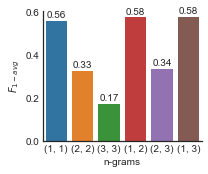

In [109]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.barplot(
    np.arange(len(n_gram_list)),
    np.array(n_grams_score),
    ax=ax)
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        xytext=(0, 1),
        textcoords='offset points')
ax.set_xticklabels(n_gram_list)
ax.set_ylabel(r"$F_{1-avg}$")
ax.set_xlabel("n-grams")
sns.despine()
plt.tight_layout()
fig.savefig(save_dir + "ngram_study.pdf")

__Observation__:
- with monograms, we attain the highest average F1 score, it is unnecessary to build bigrams or trigrams

## Study of performance vs max features
Here we look at the effect of input max features.

In [114]:
max_features_list =np.logspace(2.8, 4.5, 10 , dtype=int)
best_params = {'C': 1., 'kernel': 'linear'}
max_features_score = []

for max_feature in max_features_list:
    # cross validation
    params_vectorizer = {"max_features": max_feature, 
                         "ngram_range": (1, 2),
                         'tokenizer' :tokenize, 
                         'lowercase':False}

    SVM_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**params_vectorizer)),
        ('clf', OneVsRestClassifier(CalibratedClassifierCV(SVC(**best_params)))),
    ])

    SVM_pipeline.fit(X_train, y_train)
    y_pred_svm = SVM_pipeline.predict(X_test)
    y_pred_proba_svm = SVM_pipeline.predict_proba(X_test)
    y_pred_new_svm = get_best_tags(y_pred_svm, y_pred_proba_svm)

    score_svm = evaluate(
        y_test,
        y_pred_new_svm,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)

    print('Test score: {0:.2f}'.format(score_svm))
    max_features_score.append(score_svm)

Test score: 0.44
Test score: 0.49
Test score: 0.52
Test score: 0.54
Test score: 0.55
Test score: 0.56
Test score: 0.56
Test score: 0.57
Test score: 0.57
Test score: 0.58


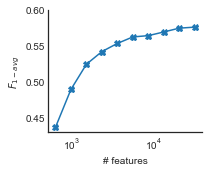

In [115]:
fig, ax = plt.subplots(figsize=(3,2.5))
ax.semilogx(max_features_list,  max_features_score, marker="X")
ax.set_ylabel(r"$F_{1-avg}$")
ax.set_xlabel("# features")
ax.set_ylim(0.43,0.6)
sns.despine()
plt.tight_layout()
fig.savefig(save_dir + "feature_num_study.pdf")

## Saving necessary modules for best model

In [116]:
import pickle
with open('binarizer.pk', 'wb') as fin:
    pickle.dump(lb, fin)

In [117]:
X_train.to_csv("X_train.csv", header=True)
X_test.to_csv("X_test.csv", header=True)
np.save("y_test.npy", y_test )

In [118]:
nx.write_gpickle(G_tags, "G_tags.gpickle")

__Observation__:
- the performance saturates when we approach high number of features, the increase is logarithmic. From 20000 features onwards, the test score attains 0.59.

# Unsupervised learning
In this section, we will train 3 models: LSA (NMF+Forbenius), PLSA (NMF+KL divergence), and LDA. Then we will compare the their performance. The number of topics is determined by SVD + the elbow method, and *Rate of Perplexity Change (RPC)* from LDA.

Using the novel metric RPC defined by RPC(i) = |(P_i-P_i-1)/(t_i-t_i-1)|, where P represents the perplexity and t the number of topics, this overcomes weaknesses on the selection of an appropriate number of topics in LDA modelling based on only the perplexity measure (it is less stable because it depends on seeds).

Rather than choosing among several numbers of topics over a potentially large range where perplexity fluctuates, the quantity defined as the changepoint of rate of perplexity change can be chosen as to be the most appropriate number of topics from a heuristic analysis.

Ref: Zhao et al. BMC Bioinformatics 2015, 16(Suppl 13):S8 http://www.biomedcentral.com/1471-2105/16/S13/S8

## Determining number of topics using truncated SVD
Using SVD (Singular Value Decomposition) to determine the number of topics for the training of models.

In [119]:
from sklearn.decomposition import TruncatedSVD

# Prep text body
X_body = df_text[["TITLE_LEMMATIZED", "BODY_LEMMATIZED"]].apply(
    lambda x: ' '.join(x) if pd.notnull(x["TITLE_LEMMATIZED"]) else x["BODY_LEMMATIZED"],
    axis=1)

n_components = 2750
params_vectorizer = {
    "max_features": 5200,
    "ngram_range": (1, 1),
    'tokenizer': tokenize,
    'lowercase': False
}
count_vect = CountVectorizer(**params_vectorizer)
svd = TruncatedSVD(n_components=n_components)

X_body_vect = count_vect.fit_transform(X_body)

#Fit the SVD model
print("Fitting the SVD model with "
      "count features...")

X_body_svd = svd.fit_transform(X_body_vect)
X_body_cumsum = np.cumsum(svd.explained_variance_ratio_)
count_feature_names = count_vect.get_feature_names()

Fitting the SVD model with count features...


In [120]:
# Save non supervised input data
X_body.to_csv("X_train_nmfkl.csv", index=True, header=True)

In [121]:
n_top_words = 50
message = ""
sorted_SVD = sorted(
            list(zip(svd.components_[0], count_feature_names)),
            key=itemgetter(0),
            reverse=True)
message += ", ".join([i[1] for i in sorted_SVD[:n_top_words]])
print("\nTopics in SVD model :")
print(message)


Topics in SVD model :
tz, abbr, secondsfromgmt, 10800, 14400, 3600, 18000, 7200, gmt-4, 21600, cet, gmt-3, gmt-5, 25200, gmt-6, gmt, gmt+3, 28800, 39600, eet, gmt+11, list, show, currently, full, time, data, try, value, one, function, create, error, make, add, example, method, call, object, user, find, also, change, first, problem, new, see, run, return, element


With 2750 components, 97.5% of the data is retained.


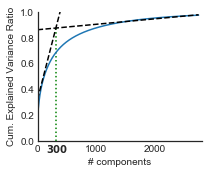

In [122]:
from scipy.interpolate import InterpolatedUnivariateSpline

fig, ax = plt.subplots(figsize=(3, 2.5))

x = np.arange(n_components)
y = X_body_cumsum
ax.plot(x, y)
ax.tick_params('y')
ax.set_xlabel("# components")
ax.set_ylabel("Cum. Explained Variance Ratio")

# determination of inflexion points
## line 1
x1 = x[0:300]
y1 = (y[0] - y[300]) / (x[0] - x[300]) * x1 + y[30]
new_x1 = np.arange(500)
f = InterpolatedUnivariateSpline(x1, y1)
new_y1 = f(new_x1)

## line 2
x2 = x[1400:]
y2 = (y[1400] - y[-1]) / (x[1400] - x[-1]) * x2 + y[900]
new_x2 = np.arange(2750)
f2 = InterpolatedUnivariateSpline(x2, y2)
new_y2 = f2(new_x2)

## plot inflexion lines
ax.plot(new_x1, new_y1, color='black', linestyle='dashed')
ax.plot(new_x2, new_y2, color='black', linestyle='dashed')
ylim = ax.get_ylim()
ax.vlines(310, 0., 0.88, color="green", linestyle='dotted')
ax.text(150, -0.09, r"$\mathbf{300}$")
ax.set_ylim(0, 1)
ax.set_xlim(0,2800)
sns.despine()
plt.tight_layout()
fig.savefig(save_dir+"svd_cumsum.pdf")
print("With %d components, %.1f%% of the data is retained." %
      (n_components, 100 * X_body_cumsum[-1]))

__Observation__:
- with SVD, we observe that with 2750 components, we retain 97.5% of the data
- with the elbow method, we observe that the number of topics that can be generated is around 300

## Topic modeling with LSA (NMF+Frobenius)

__Name Attribution to topics__ 
- attributed by looking at the top 100 word distribution of each topic, then retain the 2 most probable words that match words in the tags_reduced_quartile. If no match is found, attribute 'UNKNOWN'.

__Tags Attribution to documents__
- tags are recommended to the document by looking over the probability of topic distribution, at most 3 tags are recommended to a document. If no preponderant topic is found, then the document will not be given a tag.

__Note__: to decide if a topic is preponderant to a document or the words are suitable for a topic, we have to deal with the definition of a probability threshold. In the following, we have included the study of the probability threhosld on the performance.

In [123]:
from sklearn.decomposition import NMF
    
n_chosen_components = 5200
n_top_words = 20
n_topics = 300

params_vectorizer = {"max_features": n_chosen_components, "ngram_range": (1, 1),
                     'tokenizer' :tokenize, 'lowercase':False}

count_vect = CountVectorizer(**params_vectorizer)
X_NMF = count_vect.fit_transform(X_body)

In [124]:
#Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with "
      "tf-idf features, num_topics =%d..." %n_topics)  
num_topics = np.linspace(120,240,6, dtype=int)

print("Processing num topic %d " % (n_topics))
nmf_fr = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_NMF)
count_feature_names = count_vect.get_feature_names()

Fitting the NMF model (Frobenius norm) with tf-idf features, num_topics =300...
Processing num topic 300 


In [125]:
n_top_words = 10
count_feature_names = count_vect.get_feature_names()
#print("\nTopics in NMF model (Frobenius norm):")
#print_top_words(nmf_fr, tfidf_feature_names, n_top_words)

In [126]:
df_top_words_nmf_fr = pd.DataFrame(
    nmf_fr.components_, columns=count_feature_names)
dict_topicnames_nmf_fr, topicnames_nmf_fr = topic_name_attribution(df_top_words_nmf_fr,
                                                     tags_key_reduced_quartile)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2505: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [127]:
# Create Document - Topic Matrix
index_topicnames_fr = list(dict_topicnames_nmf_fr.keys())
nmf_fr_output = nmf_fr.transform(X_NMF)[:, index_topicnames_fr]


def potential_tags(data, threshold=0.1):
    """
    attribute potential tags to each document
    """
    #pdb.set_trace()
    sorted_data = sorted(data.items(), key=itemgetter(1), reverse=True)
    tags_temp = [k.split(',') for k, v in sorted_data if v > threshold]

    tags_temp = [item for sublist in tags_temp for item in sublist]
    # we set 5 tags maximum
    if len(tags_temp) > 3:
        tags_temp = tags_temp[:3]

    # if no tags have a value above the threshold, attribute no tags,
    # this is going to be useful for the evaluation
    if not tags_temp:
        tags_temp = ["No tags"]  #[k.split(',') for k, v in sorted_data][0]

    # set is used to avoid redundancy
    tags = list(set(tags_temp))

    return tags


# Make the pandas dataframe
df_document_topic_nmf_fr = pd.DataFrame(
    np.round(nmf_fr_output, 2), columns=topicnames_nmf_fr, index=X_body.index)

threshold_list = np.arange(0, 0.2, 0.04)
for i in range(len(threshold_list)):
    kwds = {'threshold': threshold_list[i]}
    dominant_topic_nmf_fr = df_document_topic_nmf_fr.apply(
        potential_tags, **kwds, axis=1)
    df_text.loc[df_document_topic_nmf_fr.index, 'POTENTIAL_TAGS_NMFFR_THRE_' +
                str(np.round(threshold_list[i], 2))] = dominant_topic_nmf_fr

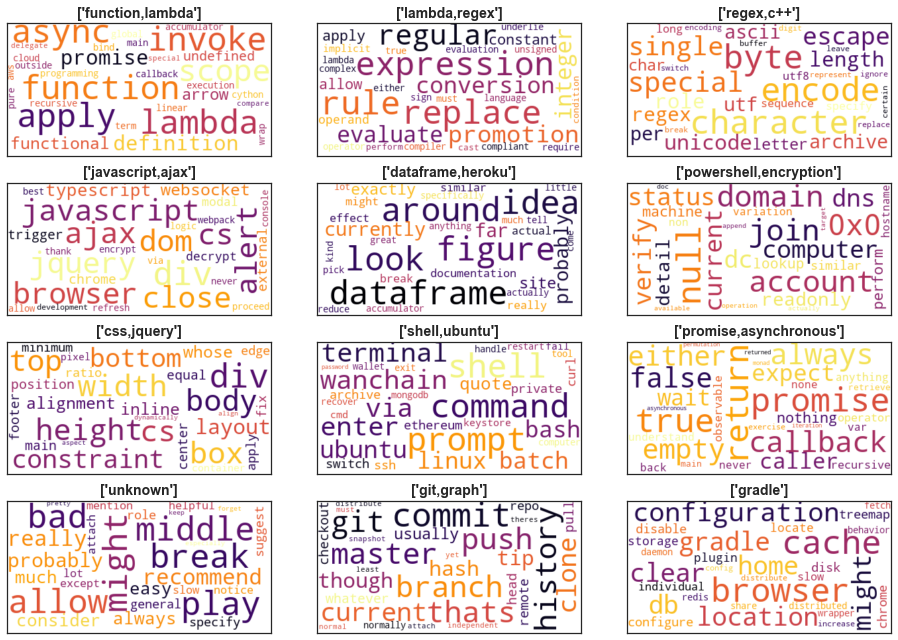

In [128]:
from wordcloud import WordCloud
sns.set_style('white')

n_top = 30
fig, axes = plt.subplots(4, 3, figsize=(14, 9))
ax = axes.flatten()
i = 0
index_topicnames = list(dict_topicnames_nmf_fr.keys())

for k in df_top_words_nmf_fr.loc[index_topicnames].sample(
        12, random_state=42).index:
    # take relative word frequencies into account, lower max_font_size
    df_top_words_sorted = df_top_words_nmf_fr.loc[k].sort_values(
        ascending=False)
    wordcloud = WordCloud(
        background_color="white",
        max_words=n_top,
        max_font_size=50,
        colormap="inferno",
        relative_scaling=.2).generate(' '.join(
            df_top_words_sorted[:n_top].index))

    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(
        "%s" % dict_topicnames_nmf_fr[k], fontsize=14, fontweight="bold")

    i += 1

plt.tight_layout(w_pad=-4., h_pad=1)
#fig.savefig("topics_word_cloud.pdf")

## Topic modeling with PLSA (NMF+KL)

In [129]:
#Fit the NMF model
print("Fitting the NMF model (KL divergence) with "
      "tf-idf features, num_topics =%d..." % n_topics)
nmf_KL = NMF(
    n_components=n_topics,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha=.1,
    l1_ratio=.5).fit(X_NMF)

Fitting the NMF model (KL divergence) with tf-idf features, num_topics =300...


In [130]:
df_top_words_nmf_KL = pd.DataFrame(
    nmf_KL.components_, columns=count_feature_names)
dict_topicnames_nmf_kl, topicnames_nmf_kl = topic_name_attribution(df_top_words_nmf_KL,
                                                     tags_key_reduced_quartile)

In [131]:
# Create Document - Topic Matrix
index_topicnames_KL = list(dict_topicnames_nmf_kl.keys())
nmf_KL_output = nmf_KL.transform(X_NMF)[:,index_topicnames_KL]

# Make the pandas dataframe
df_document_topic_nmf_KL = pd.DataFrame(
    np.round(nmf_KL_output, 2), columns=topicnames_nmf_kl, index=X_body.index)

#dominant_topic_nmf_KL = df_document_topic_nmf_KL.apply(potential_tags, axis=1)
for i in range(len(threshold_list)):
    kwds = {'threshold': threshold_list[i]}
    dominant_topic_nmf_KL = df_document_topic_nmf_KL.apply(
        potential_tags, **kwds, axis=1)
    df_text.loc[df_document_topic_nmf_KL.index, 'POTENTIAL_TAGS_NMFKL_THRE_' +
                str(np.round(threshold_list[i],2))] = dominant_topic_nmf_KL

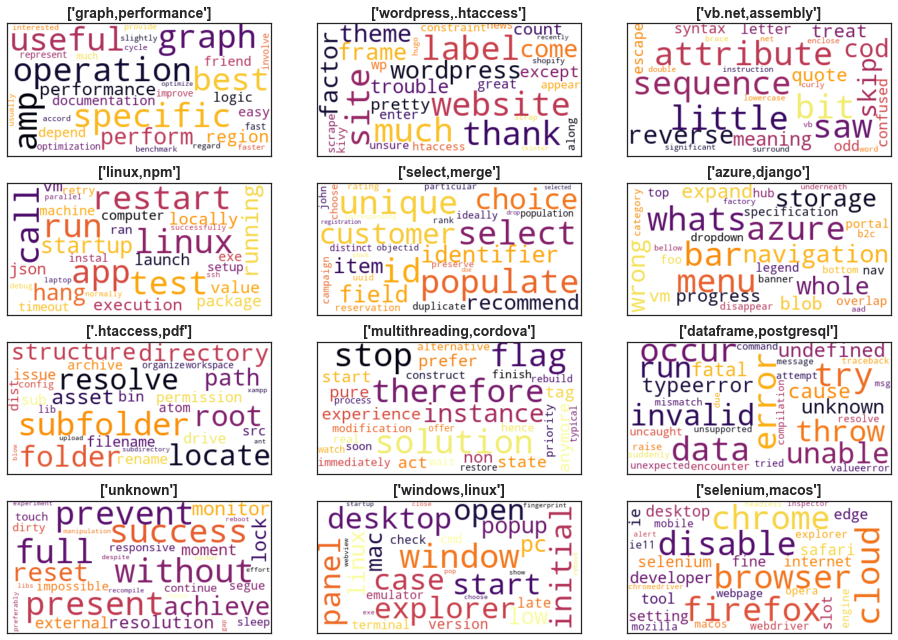

In [132]:
n_top = 30
fig, axes = plt.subplots(4, 3, figsize=(14, 9))
ax = axes.flatten()
i = 0
index_topicnames = list(dict_topicnames_nmf_kl.keys())

for k in df_top_words_nmf_KL.loc[index_topicnames].sample(
        12, random_state=42).index:
    # take relative word frequencies into account, lower max_font_size
    df_top_words_sorted = df_top_words_nmf_KL.loc[k].sort_values(
        ascending=False)
    wordcloud = WordCloud(
        background_color="white",
        max_words=n_top,
        max_font_size=50,
        colormap="inferno",
        relative_scaling=.2).generate(' '.join(
            df_top_words_sorted[:n_top].index))

    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(
        "%s" % dict_topicnames_nmf_kl[k], fontsize=14, fontweight="bold")

    i += 1

plt.tight_layout(w_pad=-4., h_pad=1)
#fig.savefig("topics_word_cloud.pdf")

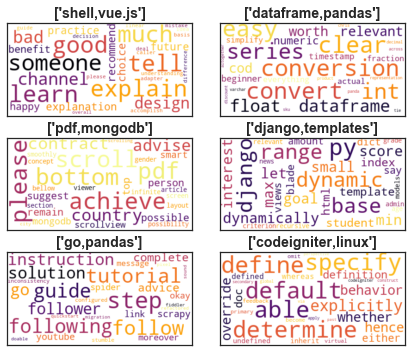

In [133]:
n_top = 30
fig, axes = plt.subplots(3, 2, figsize=(7, 5))
ax = axes.flatten()
i = 0
index_topicnames = list(dict_topicnames_nmf_kl.keys())

for k in df_top_words_nmf_KL.loc[index_topicnames].sample(
        6, random_state=412).index:
    # take relative word frequencies into account, lower max_font_size
    df_top_words_sorted = df_top_words_nmf_KL.loc[k].sort_values(
        ascending=False)
    wordcloud = WordCloud(
        background_color="white",
        max_words=n_top,
        max_font_size=50,
        colormap="inferno",
        relative_scaling=.2).generate(' '.join(
            df_top_words_sorted[:n_top].index))

    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(
        "%s" % dict_topicnames_nmf_kl[k], fontsize=14, fontweight="bold")

    i += 1

plt.tight_layout(w_pad=-4, h_pad=.5)
fig.savefig(save_dir + "topics_word_cloud_KL.pdf")

## Topic Modeling using LDA

In [135]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = np.linspace(120, 360, 7, dtype=int)

if l_crossval:
    num_cv = 3
    perplexities = [[] for x in range(len(num_topics))]
    ldas2 = [[] for x in range(len(num_topics))]

    for i in range(len(num_topics)):
        for cv in range(num_cv):
            print("%d: processing num topic %d " % (cv, num_topics[i]))
            lda = LatentDirichletAllocation(
                n_components=num_topics[i],
                max_iter=10,
                learning_method='online',
                learning_offset=50.,
                total_samples=2000)

            ldas2[i].append(lda.fit(X_NMF))
            perplexities[i].append(lda.perplexity(X_NMF))

else:
     perplexities = [[
        2730.042169502154, 2657.850198542552, 2732.1554380872576
    ], [3121.5851356346216, 3160.3933702070544, 3078.5464417945764], [
        3449.4380844531966, 3489.793489956359, 3702.514848183639
    ], [3908.6500865491134, 4100.030580369049, 4189.624879016464], [
        4558.44572249753, 4396.575439797789, 4711.380212690162
    ], [4816.138272701868, 4908.89953730471, 4882.461734075558],
                    [5718.505960887363, 5258.114135803885, 5405.5119863024165]]
    # from previous cross validation

n_topics = 300
lda_chosen = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method='online',
        learning_offset=50.,
        total_samples=2000)

lda_chosen.fit(X_NMF)
   
mean_perplexity = np.mean(perplexities, axis=-1)

### Determining number of topics with RPC

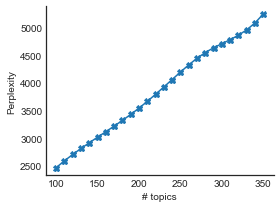

In [137]:
fig, ax = plt.subplots(1, figsize=(4, 3))

# interpolation
new_x = np.arange(100,360,10)
f = InterpolatedUnivariateSpline(num_topics, mean_perplexity)

ax.plot(new_x, f(new_x) , marker="X")
ax.set_xlabel("# topics")
ax.set_ylabel("Perplexity")
sns.despine()
plt.tight_layout()

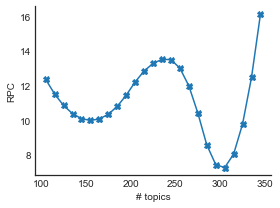

In [138]:
# calculate rpc based on interpolated functions
rpc2 = rpc_score( f(new_x), new_x)
mid_new_x = .5*(new_x[:-1] +new_x[1:])

# plot
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.plot(mid_new_x, rpc2, marker="X")
ax.set_xlabel("# topics")
ax.set_ylabel("RPC")
sns.despine()
plt.tight_layout()
fig.savefig(save_dir + "RPC.pdf")

In [139]:
tf_feature_names = count_vect.get_feature_names()
opt_lda_model = lda_chosen
df_top_words_lda = pd.DataFrame(opt_lda_model.components_, columns=tf_feature_names)
dict_topicnames_lda, topicnames_lda = topic_name_attribution(df_top_words_lda,
                                                     tags_key_reduced_quartile)

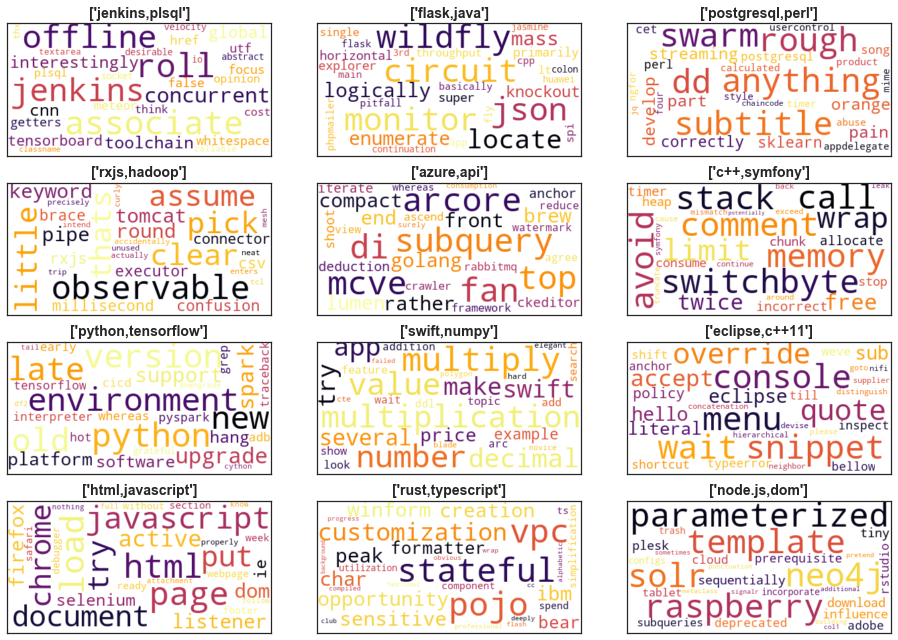

In [140]:
from wordcloud import WordCloud
sns.set_style('white')

n_top = 30
fig, axes = plt.subplots(4, 3, figsize=(14, 9))
ax = axes.flatten()
i = 0
index_topicnames = list(dict_topicnames_lda.keys())

for k in df_top_words_lda.loc[index_topicnames].sample(12,random_state=42).index:
    # take relative word frequencies into account, lower max_font_size
    df_top_words_sorted = df_top_words_lda.loc[k].sort_values(ascending=False)
    wordcloud = WordCloud(
        background_color="white",
        max_words=n_top,
        max_font_size=50,
        colormap="inferno",
        relative_scaling=.2).generate(' '.join(
            df_top_words_sorted[:n_top].index))

    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title("%s" % dict_topicnames_lda[k], fontsize=14, fontweight="bold")

    i += 1

plt.tight_layout(w_pad=-4., h_pad=1)
#fig.savefig("topics_word_cloud.pdf")

__Observation__:
- the topic names are very coherent with the word distribution 

In [141]:
# Create Document - Topic Matrix
index_topicnames_lda = list(dict_topicnames_lda.keys())
lda_output = opt_lda_model.transform(X_LDA)[:, index_topicnames_lda]

# Make the pandas dataframe
df_document_topic_lda = pd.DataFrame(
    np.round(lda_output, 2), columns=topicnames_lda, index=X_body.index)

#dominant_topic_lda = df_document_topic_lda.apply(potential_tags, axis=1)

for i in range(len(threshold_list)):
    kwds = {'threshold': threshold_list[i]}
    dominant_topic_lda = df_document_topic_lda.apply(
        potential_tags, **kwds, axis=1)
    df_text.loc[df_document_topic_lda.index, 'POTENTIAL_TAGS_LDA_THRE_' +
                str(np.round(threshold_list[i],2))] = dominant_topic_lda

## Unsupervised learning model performance
Performance evaluation for unsupervised learning models use both avg F1 score and no tag ratio. The avg F1 score is calculated only on entries that have tags, the no tag ratio is calculated on all entries.

In [142]:
columns_to_keep = []

for i in range(len(threshold_list)):
    columns_to_keep += [
        'POTENTIAL_TAGS_LDA_THRE_' + str(np.round(threshold_list[i], 2))
    ]
    columns_to_keep += [
        'POTENTIAL_TAGS_NMFFR_THRE_' + str(np.round(threshold_list[i], 2))
    ]
    columns_to_keep += [
        'POTENTIAL_TAGS_NMFKL_THRE_' + str(np.round(threshold_list[i], 2))
    ]

df_text_reduced_clusterized = pd.merge(
    df_tags_reduced_sampled,
    pd.DataFrame(df_text[columns_to_keep]),
    left_index=True,
    right_index=True)

In [143]:
columns_to_show = ["BODY","TAGS_MODIFIED"] + columns_to_keep
df_text_reduced_clusterized[columns_to_show].sample(
    10, random_state=42)

,BODY,TAGS_MODIFIED,POTENTIAL_TAGS_LDA_THRE_0.0,POTENTIAL_TAGS_NMFFR_THRE_0.0,POTENTIAL_TAGS_NMFKL_THRE_0.0,POTENTIAL_TAGS_LDA_THRE_0.04,POTENTIAL_TAGS_NMFFR_THRE_0.04,POTENTIAL_TAGS_NMFKL_THRE_0.04,POTENTIAL_TAGS_LDA_THRE_0.08,POTENTIAL_TAGS_NMFFR_THRE_0.08,POTENTIAL_TAGS_NMFKL_THRE_0.08,POTENTIAL_TAGS_LDA_THRE_0.12,POTENTIAL_TAGS_NMFFR_THRE_0.12,POTENTIAL_TAGS_NMFKL_THRE_0.12,POTENTIAL_TAGS_LDA_THRE_0.16,POTENTIAL_TAGS_NMFFR_THRE_0.16,POTENTIAL_TAGS_NMFKL_THRE_0.16
Id,,,,,,,,,,,,,,,,,
50434797,<p>Hi I tried to set session using PHP but it ...,"[javascript, php, jquery, html]","[go, redirect, session]","[redirect, php, session]","[azure, html, matplotlib]","[go, redirect, session]","[redirect, php, session]","[azure, html, matplotlib]","[go, redirect, session]","[redirect, php, session]","[azure, html, matplotlib]","[go, redirect, session]","[redirect, php, session]","[azure, html, matplotlib]","[go, redirect, session]","[redirect, php, session]","[azure, html, matplotlib]"
49043655,<p>This is a duplicate question asked 2 years ...,"[javascript, file, unit-testing]","[go, assembly, groovy]","[function, lambda, jquery]","[random, validation, testing]","[go, assembly, groovy]","[function, lambda, jquery]","[random, validation, testing]","[go, assembly, groovy]","[function, lambda, jquery]","[random, validation, testing]","[go, assembly, groovy]","[function, lambda, jquery]","[validation, testing]","[go, assembly, groovy]",[No tags],"[validation, testing]"
50450652,<p>What is the list of ways to reference the r...,"[reactjs, ecmascript-6, redux]","[go, redux, api]","[.net, dictionary, assembly]","[unknown, redux, reactjs]","[go, redux, api]","[.net, dictionary, assembly]","[unknown, redux, reactjs]","[go, redux, api]","[.net, dictionary, assembly]","[unknown, redux, reactjs]","[go, redux, api]","[.net, dictionary, assembly]","[redux, reactjs]","[go, api]","[.net, assembly]","[redux, reactjs]"
50446699,<p>Currently I'm trying to Hardcode some value...,"[java, testing]","[go, class, java]","[eclipse, class, java]","[class, angularjs, uwp]","[go, class, java]","[eclipse, class, java]","[class, angularjs, uwp]","[go, class, java]","[eclipse, class, java]","[angularjs, uwp]","[go, class, java]",[No tags],[No tags],"[class, java]",[No tags],[No tags]
48437908,<p>I have this sample data.</p>\n\n<pre><code>...,[sql-server],"[go, numpy, scala]","[random, csv, dataframe]","[unknown, dplyr, xamarin]","[go, numpy, scala]","[random, csv, dataframe]","[unknown, dplyr, xamarin]","[go, numpy, scala]","[random, csv, dataframe]",[No tags],"[go, numpy, scala]","[random, csv, dataframe]",[No tags],"[go, scala]","[csv, dataframe]",[No tags]
50425216,<p>I have a problem with static linking of qt ...,[qt],"[windows, c++, string]","[c++, maven, webpack]","[webpack, qt, url]","[windows, c++, string]","[c++, maven, webpack]","[webpack, qt, url]","[windows, c++, string]","[c++, maven, webpack]","[webpack, qt, url]","[windows, c++, string]","[maven, webpack]","[webpack, url]","[windows, c++]","[maven, webpack]",[No tags]
49804536,<p>I am trying to download an image from a ser...,"[javascript, node.js, ssl, https]","[windows, c++, http]","[ruby, ubuntu, pdf]","[express, http, facebook]","[windows, c++, http]","[ruby, ubuntu, pdf]","[express, http, facebook]","[windows, c++, http]","[ruby, ubuntu]",[No tags],"[windows, c++, http]",[No tags],[No tags],"[windows, c++, http]",[No tags],[No tags]
50462096,<p>I have a query that groups the results (lar...,[mongodb],"[go, sql, rest]","[performance, algorithm]","[database, string, list]","[go, sql, rest]","[performance, algorithm]","[database, string, list]","[go, sql, rest]","[performance, algorithm]","[database, string, list]",[go],"[performance, algorithm]","[database, string, list]",[No tags],"[performance, algorithm]",[No tags]
50447314,<p>I have defined a converter in my project. I...,"[c#, wpf, xaml]","[go, assembly, xaml]","[validation, testing, algorithm]","[python, parsing, testing]","[go, assembly, xaml]

In [144]:
mlb_tagslist = tuple(
    set(["No tags", "unknown"] +
        df_text_reduced_clusterized.TAGS_MODIFIED.sum()))
mlb = MultiLabelBinarizer(classes=mlb_tagslist)
y_true = mlb.fit_transform(df_text_reduced_clusterized.TAGS_MODIFIED)
score_ldas = []
no_tag_ldas = []

for i in range(len(threshold_list)):
    y_pred_lda = mlb.fit_transform(
        df_text_reduced_clusterized["POTENTIAL_TAGS_LDA_THRE_"
                                    + str(round(threshold_list[i], 2))])

    score_lda = evaluate(
        y_true,
        y_pred_lda,
        binarizer=mlb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)
    #print('Test score: {0:.2f}'.format(score_lda))
    score_ldas.append(score_lda)

    y_pred_text_lda = mlb.fit_transform(
        df_text["POTENTIAL_TAGS_LDA_THRE_" + str(round(threshold_list[i], 2))])
    no_tag_score_lda = no_tag_percentage_score(y_pred_text_lda, mlb)
    no_tag_ldas.append(no_tag_score_lda)

In [156]:
# Save files for deployment
np.save("index_y_true_nmf.npy", list(df_text_reduced_clusterized.TAGS_MODIFIED.index))
np.save("y_true_nmf.npy", y_true)
with open('new_binarizer.pk', 'wb') as fin:
    pickle.dump(mlb, fin)

In [146]:
score_nmf_frs = []
no_tag_nmf_frs = []

for i in range(len(threshold_list)):
    y_pred_nmf_fr = mlb.fit_transform(
        df_text_reduced_clusterized["POTENTIAL_TAGS_NMFFR_THRE_"
                                    + str(round(threshold_list[i], 2))])

    score_nmf_fr = evaluate(
        y_true,
        y_pred_nmf_fr,
        binarizer=mlb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)
    #print('Test score: {0:.2f}'.format(score_nmf_fr))
    score_nmf_frs.append(score_nmf_fr)

    y_pred_text_nmf_fr = mlb.fit_transform(
        df_text["POTENTIAL_TAGS_NMFFR_THRE_"
                + str(round(threshold_list[i], 2))])

    no_tag_score_nmf_fr = no_tag_percentage_score(y_pred_text_nmf_fr, mlb)
    no_tag_nmf_frs.append(no_tag_score_nmf_fr)

In [147]:
score_nmf_kls = []
no_tag_nmf_kls = []
for i in range(len(threshold_list)):
    y_pred_nmf_kl = mlb.fit_transform(
        df_text_reduced_clusterized["POTENTIAL_TAGS_NMFKL_THRE_"
                                    + str(round(threshold_list[i], 2))])

    score_nmf_kl = evaluate(
        y_true,
        y_pred_nmf_kl,
        binarizer=mlb,
        G_tags=G_tags,
        l_print_errors=False,
        l_deduplication=True)
    #print('Test score: {0:.2f}'.format(score_nmf_kl))
    score_nmf_kls.append(score_nmf_kl)

    y_pred_text_nmf_kl = mlb.fit_transform(
        df_text["POTENTIAL_TAGS_NMFKL_THRE_"
                + str(round(threshold_list[i], 2))])
    no_tag_score_nmf_kl = no_tag_percentage_score(y_pred_text_nmf_kl, mlb)
    no_tag_nmf_kls.append(no_tag_score_nmf_kl)

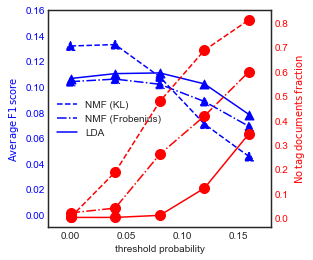

In [148]:
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(threshold_list, score_nmf_kls, marker = "^", linestyle="dashed", 
        s=80, color="b")
ax.scatter(threshold_list, score_nmf_frs, marker = "^", linestyle="dashdot", 
        s=80, color="b")
ax.scatter(threshold_list, score_ldas, marker = "^", linestyle="solid", 
        s=80, color="b")
ax.plot(threshold_list, score_nmf_kls, linestyle="dashed", label="NMF (KL)", 
           color="b")
ax.plot(threshold_list, score_nmf_frs, linestyle="dashdot", 
           label="NMF (Frobenius)", color="b")
ax.plot(threshold_list, score_ldas, linestyle="solid", 
           label="LDA", color="b")
ax2 = ax.twinx()
ax2.plot(threshold_list, no_tag_nmf_kls, marker = "o", linestyle="dashed", 
         markersize=10, color="r")
ax2.plot(threshold_list, no_tag_nmf_frs, marker = "o", linestyle="dashdot", 
         markersize=10, color="r")
ax2.plot(threshold_list, no_tag_ldas, marker = "o", linestyle="solid", 
         markersize=10, color="r")
ax.tick_params('y', colors='b')
ax.set_ylim(-0.01,0.16)
ax.set_xlim(-0.02,0.18)
ax2.tick_params('y', colors='r')
ax2.set_ylabel(r"$\mathrm{No\,tag\,documents\,fraction}$", color='r')
ax.set_ylabel(r"$\mathrm{Average\,F1\,score}$", color='b')

ax.set_xlabel("threshold probability")
ax.legend(loc='center left')
plt.show()


__Observation__:
- Average F1 score is only evaluated on examples that have true labels. A good clustering should have a high average F1 score. In this case, the threshold probability should be 0 for all models
- No tag ratio is evaluated on the whole document set. It should be kept at a low value. The threshold probabilty should be set to 0 for all models
- so we have chosen 0 as the threshold value.

In [149]:
pd.DataFrame(
    [ [score_nmf_frs[0], no_tag_nmf_frs[0]],
     [score_nmf_kls[0], no_tag_nmf_kls[0]], [score_ldas[0], no_tag_ldas[0]]],
    index=["LSA", "PLSA", "LDA"],
    columns=["AVG F1 SCORE", "NO TAG SCORE"])

,AVG F1 SCORE,NO TAG SCORE
LSA,0.103891,0.020112
PLSA,0.131755,0.001701
LDA,0.106318,0.001661


# Conclusion:
__EDA__:
- We have defined a preprocessing pipeline for unstructure text.
- We have grouped similar tags and presented them in a graph structure to define a lenient evaluation metric.

__Classification__:
- As compared to supervised learning, the AVG F1 scores best are very close to the baseline supervised learning models.
- The no tag score indicates the fraction of documents which are not attributed a tag. It would be great to minimize this score.
- A way to compare the performance among all these unsupervised models, AVG F1 score needs to be high and the no tag score has to below, therefore the best performance is obtained with PLSA (NMF + KL) model.
- We conclude that the best models are: TFIDF + SVM for the supervised approach, and PLSA model in the unsupervised approach.

__Deployment__:
- These two best models will be trained in the best_model.py and deployed to https://so-tags-recommender.herokuapp.com

__Perspective__:
- The metric might not be global and complete enough to evaluate the performance of unsupervised models.